In [53]:
import pandas as pd
import numpy as np
import pydot
from IPython.display import Image, display

In [2]:
df = pd.read_csv('tennis.csv')
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [7]:
df[df['outlook']=='sunny']

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
10,sunny,mild,normal,True,yes


In [3]:
class Node:
    def __init__(self, label, gini, type="categorical"):
        self.type = type
        self.label = label
        self.branches = dict()
        self.gini = gini

    def add_branch(self, label, node):
        assert label not in self.branches.keys(), f"Label {label} already exist in this node branches"

        self.branches[label] = node

class Tree:
    def __init__(self):
        self.root_node = None

    def __gini_impurity(df, key):
        unique_vals = df[key].unique()
        total_count = len(df[key])

        assert total_count > 0

        total_squared_prob = 0

        for val in unique_vals:
            val_count = len(df[df[key] == val])

            total_squared_prob += np.square(val_count/total_count)

        return 1 - total_squared_prob


    def add_branch(self, name, value):
        self.branches[name] = value

## Categorical dataset

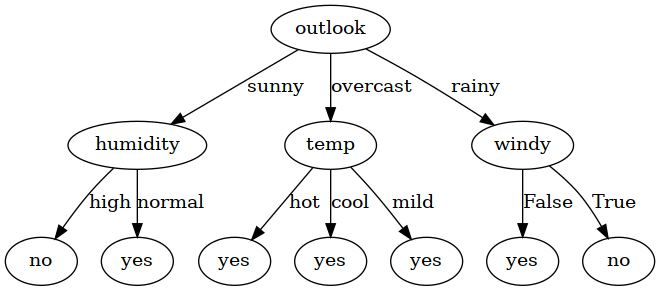

In [55]:
def gini_impurity(value_dict, total_count):
    '''Calculate (actual) gini impurity for the labels'''

    total_squared_prob = 0

    for key in value_dict.keys():
        val_count = value_dict[key]
        total_squared_prob += np.square(val_count/total_count)

    return 1 - total_squared_prob

def gini_for_key(df, key):
    '''Calculate gini impurity for given key (column)'''

    unique_vals = df[key].unique() # branches in the corresponding column
    total_count = len(df[key])

    total_gini = 0

    # calculate gini impurity for each branch, then sum all up with their corresponding weights
    for unique_val in unique_vals:
        splitted_labels = df[df[key]==unique_val].iloc(axis=1)[-1] # (Series) labels of the branch
        splitted_count = len(splitted_labels)

        total_gini += splitted_count/total_count * gini_impurity(splitted_labels.value_counts().to_dict(),splitted_count)
    
    return total_gini

def choose_root(df):
    root_candidates = df.columns.to_list()[:-1] # get possible keys
    ginis = []

    for key in root_candidates:
        ginis.append(gini_for_key(df, key))

    min_gini_idx = np.array(ginis).argmin(axis=0)

    return root_candidates[min_gini_idx], ginis[min_gini_idx]

def queue_init(df):
    root_candidate = choose_root(df)
    root_node = Node(root_candidate[0], root_candidate[1])

    root_queue_element = {
        'parent_node': root_node,
        'branches': df[root_candidate[0]].unique(),
        'df': df
    }

    return root_queue_element

def final_decision(labels, vote=False):
    '''labels (pandas.Series)'''

    if not vote:
        assert len(labels.unique()) == 1, "Voting must be used for impure set of decisions"
        
        return labels.unique()[0]
    else:
        pass



def build_tree(df):
    queue = [queue_init(df)]
    root_node = queue[0]['parent_node']
    
    while len(queue) > 0:
        queue_ele = queue.pop(0)

        for branch in queue_ele['branches']:
            parent_df = queue_ele['df']
            parent_label = queue_ele['parent_node'].label

            curr_df = parent_df[parent_df[parent_label] == branch]
            curr_df = curr_df.loc(axis=1)[curr_df.columns != parent_label]
            
            new_candidate = choose_root(curr_df)
            new_node = Node(new_candidate[0], gini= new_candidate[1])
            queue_ele['parent_node'].add_branch(branch, new_node)

            if new_candidate[1] < 1e-3:
                final_branches = curr_df[new_candidate[0]].unique()

                for final_branch in final_branches:
                    final_labels = curr_df[curr_df[new_candidate[0]]==final_branch].iloc(axis=1)[-1]
                    decision = final_decision(final_labels)
                    new_node.branches[final_branch] = Node(decision, gini_impurity(final_labels.value_counts().to_dict(), len(final_labels)))

                continue
            else:
                new_queue_element = {}
                new_queue_element['parent_node'] = new_node
                new_queue_element['branches'] = curr_df.columns.unique()
                new_queue_element['df'] = curr_df

                queue.append(new_queue_element)

    return root_node

def visualize_tree(root_node):
    graph = pydot.Dot("test", graph_type="digraph")

    node_counter = 0
    graph.add_node(pydot.Node(node_counter, label=root_node.label))
    node_counter += 1

    queue = [(0, item[0], item[1]) for item in root_node.branches.items()]

    while len(queue) > 0:
        curr_item = queue.pop(0)
        graph.add_node(pydot.Node(node_counter, label=curr_item[2].label))
        graph.add_edge(pydot.Edge(curr_item[0], node_counter, label=curr_item[1]))

        for branch in curr_item[2].branches.items():
            queue.append((node_counter, branch[0], branch[1]))

        node_counter += 1

    plt = Image(graph.create_png())
    display(plt)

root_node = build_tree(df)
visualize_tree(root_node)